In [1]:
#Pkg.clone("https://github.com/jlapeyre/InverseLaplace.jl.git")

In [2]:
using Gadfly, Interact
using DataFrames
using Roots
using InverseLaplace
using Compose

In [3]:
#Plotting options

#  Colors used for plotting, based on Color Brewer 3class Set 1
blue = colorant"#377eb8"; 
red  = colorant"#e41a1c"; 

# Frequency range
ω=logspace(-2,6,1000);
j=im;

#Time range
t_min=0; t_max=10;
yt_min=0; yt_max=2;
t=linspace(t_min,t_max,300)

# Default style for plotting
properties=(Geom.line, Scale.x_log10, Guide.XLabel("Frequency (rad/s)"), 
    Theme(line_width=2pt, default_color=blue), Guide.xticks(ticks=collect(-2:5)));
propertiesMagnitude=(properties..., Guide.YLabel("|H(jω)| (dB)", orientation=:vertical),
    Coord.Cartesian(ymin=-40, ymax=20));
propertiesPhase    =(properties..., Guide.YLabel("Phase H(jω) (deg)", orientation=:vertical), 
    Coord.Cartesian(ymin=-360, ymax=360));
propertiesTime     =(Geom.line, Guide.XLabel("t"), Guide.YLabel("h(t)", orientation=:vertical), 
    Theme(line_width=2pt, default_color=blue), 
    Coord.Cartesian(xmin=t_min, xmax=t_max, ymin=yt_min, ymax=yt_max));
properties_arbitrary=(Geom.line, Guide.XLabel("t"), Guide.YLabel("Step Response", orientation=:vertical), 
    Theme(line_width=2pt, default_color=blue));

In [4]:
#helper fuctions to find step response chracteristics
function getOvershoot(t_vec, ft_vec, steadystate)
    peakvalue=findmax(ft_vec)[1]
    peaktime=t_vec[findmax(ft_vec)[2]]
    overshoot=(peakvalue-steadystate)/steadystate*100
    if (overshoot < 0.0) 
        overshoot = 0.0
    end
    return overshoot
end
function getSettling(t_vec, ft_vec, steadystate)
    settling_limit=0.1
    settlingtime=t_vec[findlast(((ft_vec-steadystate).^2 .< (steadystate*settling_limit)^2),false)]
end
function getRisetime(t_vec, ft_vec, steadystate)
    rise_limits=[0.05 0.95]    
    rise_low=t_vec[findfirst(ft_vec.<steadystate*rise_limits[1],false)]
    rise_high=t_vec[findfirst(ft_vec.<steadystate*rise_limits[2],false)]
    risetime=rise_high-rise_low
end
function getAnnotation(num, den, x_pos, y_pos)
    H(s)=num(s)/den(s);
    T(s)=H(s)/s;
    steadystate=H(0);
    
    ft_vec = [ilt(s -> T(s), τ, 64) for  τ in t]
    ft_vec[1]=0.0 #set t=0 to 0

    overshoot = getOvershoot(t,ft_vec,steadystate); 
    risetime = getRisetime(t,ft_vec,steadystate);
    settlingtime = getSettling(t,ft_vec,steadystate);
    
    overlimit=""
    if (settlingtime == t_max)
        overlimit=">"            
    end
    
    propertiesAnnotation=Guide.annotation(compose(context(), text(x_pos, y_pos, 
    "Unstable")))
    if (isempty(find(real(roots(den)).>=0)))
        propertiesAnnotation=Guide.annotation(compose(context(), text(x_pos, y_pos, 
        "Stable: \n
        Overshoot (%): $(overshoot) \n
        Rise Time: $(risetime) \n
        Settling time: $overlimit$(settlingtime)\n")))
    end    
    
    return propertiesAnnotation
end

getAnnotation (generic function with 1 method)

In [5]:
function BodePlot(H_F; extras=Coord.Cartesian(xmin=-2,xmax=6))
    H_Vec = [H_F(j*x) for x in ω];
    H_Vec = convert(Array{Complex{Float64}},H_Vec);
    
    magnitude = 20log10(abs(H_Vec))
    phase     = angle(H_Vec)/2π*360
    
    magnitudePlot = plot(x=ω, y=magnitude,propertiesMagnitude...,extras)
    phasePlot     = plot(x=ω, y=phase,  propertiesPhase...,extras)
    
    p = vstack(magnitudePlot, phasePlot)
    return p
end

BodePlot (generic function with 1 method)

In [6]:
function PoleZeroPlot(poles,zeros,x_min,x_max,y_min,y_max)
    dfp = DataFrame(x=real(poles), y=imag(poles), label="poles")
    dfz = DataFrame(x=real(zeros), y=imag(zeros), label="zeros")
    df = vcat(dfp,dfz)
    
    p_pz = plot(df, x="x", y="y", color="label", Geom.point,
        Scale.color_discrete_manual("red","blue"), Guide.xlabel("Re"), Guide.ylabel("Im"), 
    Coord.Cartesian(xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max))
    
    return p_pz
end


PoleZeroPlot (generic function with 1 method)

In [7]:
function step_response(num,den,properties)
    H(s)=num(s)/den(s);
    T(s)=H(s)/s;
    steadystate=H(0);
    
    ft_vec = [ilt(s -> T(s), τ, 64) for  τ in t]
    ft_vec[1]=0.0 #set t=0 to 0

    propertiesAnnotation = getAnnotation(num,den,t_max/3,yt_max-(yt_max-yt_min)/10);
    p_time = plot(x=t, y=ft_vec, Geom.line, propertiesAnnotation, properties...)
    return p_time    
end

step_response (generic function with 1 method)

# Cruise Control
Plant:
$$
P(s)=\frac{1}{s+a}
$$

Controller:
$$
K(s)=k_p+\frac{k_i}{s}
$$

Closed Loop transfer function
$$
\frac{V_m(s)}{V_{des}(s)} = \frac{K(s)P(s)}{1+K(s)P(s)}
$$
where
$$
K(s)P(s)=\frac{1}{s+a} \bigg(  k_p + \frac{k_i}{s} \bigg) = \frac{sk_p + k_i}{s(s+a)}
$$
Solve for numerator and denominator
$$
\frac{V_m(s)}{V_{des}(s)} = \frac{K(s)P(s)}{1+K(s)P(s)} = \frac{sk_p+k_i}{s(s+a)+sk_p+k_i}
$$
$$
=\frac{sk_p+k_i}{s^2+s(k_p+a)+k_i}
$$

Interact.Slider{Float64}(Signal{Float64}(-0.10204081632653061, nactions=0),"a",-0.10204081632653061,linspace(-5.0,5.0,50),true)

Interact.Slider{Float64}(Signal{Float64}(2.4489795918367347, nactions=0),"kₚ",2.4489795918367347,linspace(0.0,5.0,50),true)

Interact.Slider{Float64}(Signal{Float64}(9.795918367346939, nactions=0),"kᵢ",9.795918367346939,linspace(0.0,20.0,50),true)

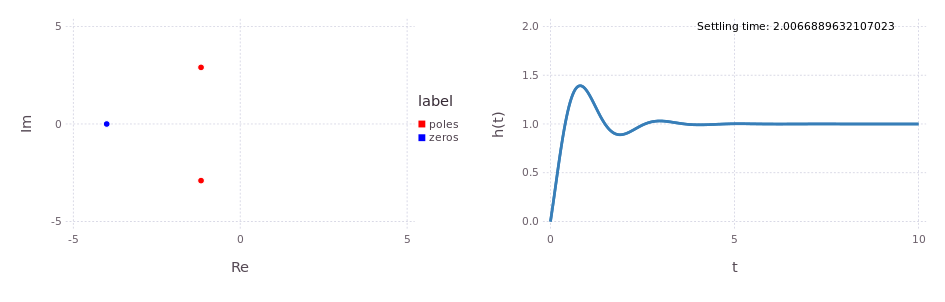

In [8]:
set_default_plot_size(25cm, 8cm);
#Cruise control
@manipulate for a in linspace(-5,5), kₚ in linspace(0,5), kᵢ in linspace(0,20)  
    #closed
    num(s)=s*kₚ+kᵢ
    den(s)=s^2+s*(kₚ+a)+kᵢ

    zeros=roots(num)
    poles=roots(den)

    p_t= step_response(num,den,propertiesTime)
    p_pz = PoleZeroPlot(poles,zeros,-5,5,-5,5)
    hstack(p_pz,p_t)
end

Interact.Slider{Float64}(Signal{Float64}(-0.10204081632653061, nactions=0),"a",-0.10204081632653061,linspace(-5.0,5.0,50),true)

Interact.Slider{Float64}(Signal{Float64}(2.4489795918367347, nactions=0),"kₚ",2.4489795918367347,linspace(0.0,5.0,50),true)

Interact.Slider{Float64}(Signal{Float64}(9.795918367346939, nactions=0),"kᵢ",9.795918367346939,linspace(0.0,20.0,50),true)

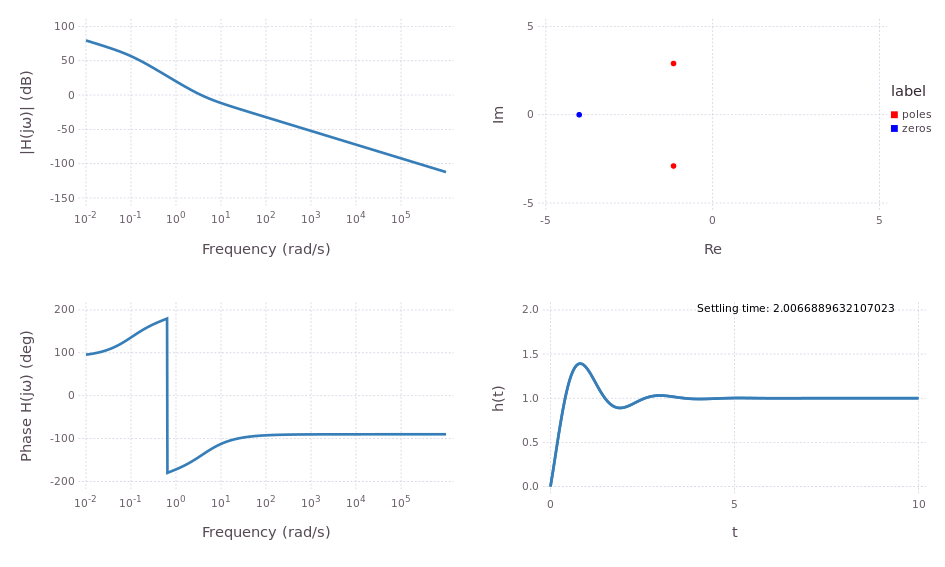

In [9]:
set_default_plot_size(25cm, 15cm);
#Cruise control
@manipulate for a in linspace(-5,5), kₚ in linspace(0,5), kᵢ in linspace(0,20)
    #open
    num_open(s)=s*kₚ+kᵢ
    den_open(s)=s*(s+a)
    H(s)= num_open(s)/den_open(s)
    
    #closed
    num(s)=s*kₚ+kᵢ
    den(s)=s^2+s*(kₚ+a)+kᵢ
    G(s)=num(s)/den(s)

    zeros=roots(num)
    poles=roots(den)
    
    p_bd = BodePlot(H);
    p_t= step_response(num,den,propertiesTime)
    p_pz = PoleZeroPlot(poles,zeros,-5,5,-5,5)
    hstack(p_bd,vstack(p_pz,p_t))
end